## Init

Imports:

In [1]:
using Pkg
Pkg.activate("../one_flav_env")

using NaNMath
using QuadGK
using DifferentialEquations
using Interpolations
using Roots
using PythonPlot
using LaTeXStrings
import SpecialFunctions: besselk
import LinearAlgebra: dot
import PhysicalConstants.CODATA2018: G, FineStructureConstant
using NaturallyUnitful
;

  Activating project at `~/Dropbox (University of Oregon)/MuC/Aria/one_flav/code/one_flav_env`


In [2]:
include("../one_flav_env/gstar.jl")
using .gstar

include("../one_flav_env/one_flav_model.jl")
import .OneFlavor: LFDM, Γ_φ_to_χe, σ_AA_to_φφ, σ_Ae_to_φχ, σ_ee_to_φφ, 
        σ_ZZ_to_φφ, Y_eq, Y_eq_ratio
;

Defaults and Constants:

In [1]:
const αEM = float(FineStructureConstant)
const Grav = ustrip(uconvert(u"GeV^-2", natural(float(G))))
const T0 = 2.348e-13 # GeV
const sW2 = .23121 # sine of weak-mixing angle squared
const cW2 = 1 - sW2
const mZ = 91.1876 # GeV
s0 = ustrip(uconvert(u"GeV^3", natural(2891.2*u"cm^-3")))
# const Mstar = 90*(2.131e-42)^2/(T0^3*8*π*Grav) # for Y_χ
const Mstar = 90*(2.131e-42)^2/(2*T0^3*8*π*Grav) # for Y_χ+Y_(χbar)
const Mstar_no_s = 3*(2.131e-42)^2/(2*T0^3*8*π*Grav) # for Y_χ+Y_(χbar)
const lifetime_conv = ustrip(unnatural(u"s", 1*u"GeV^-1"))
const h_consts = sqrt(4*π^3*Grav/45)

s_factor(T) = (T0^3*2*π^2*gstar_interp(T)/45)/s0
Mstar_s(T) = Mstar_no_s * s_factor(T)

figdir = "./"

golden_ratio = (1+sqrt(5))/2

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")
;

UndefVarError: UndefVarError: `FineStructureConstant` not defined

## Function definitions:

Random:

In [4]:
function arctanh(x)
    .5*(log(1+x) - log(1-x))
end

function bkf(u, x)
    t1 = sqrt(x/π)
    t2 = -(57+4*u)/(16*sqrt(x*π))
    t3 = (4185+24*u*(17+2*u)) / (512 * sqrt(π*x^3))
    t4 = -5*(24135+2724*u+432*u^2+64*u^3) / (8192*sqrt(π*x^5))
    return t1+t2+t3+t4
end

function bk2_ratio(x, δ)
    if x < 1e-2
        return δ^2*(1-(1-δ^2)*x^2/4)
    elseif x < 1e2/δ
        return besselk(2,x)/besselk(2,δ*x)
    else
        return exp(-(1-δ)*x)*(sqrt(δ)-15*(1-δ)/(8*x*sqrt(δ)))
    end
end

"""
    hubble(T)

Gives the Hubble constant H in GeV.

T : Temperature [GeV]
"""
function hubble(T)
    T^2 * sqrt(4*π^3*Grav*gstar_interp(T)/45)
end

"""
    reduced_H(T)

Gives H / T^2 in GeV^-1. For use in Boltzmann equations.

T : Temperature [GeV]
"""
function reduced_H(T)
    sqrt(4*π^3*Grav*gstar_interp(T)/45)
end
;

Cross-sections:

In [5]:
σ38(α, model::LFDM) = 3*4*σ_ee_to_φφ(α, model) + 4*σ_AA_to_φφ(α, model)
# the factors of 4 are for the initial spin dofs (2 for each initial particle)
# the factor of 3 is for 3 different leptons all with the same xsec

function C22(σ, x, model::LFDM)
    redh = reduced_H(model.mφ/x)
    if x < 1e-2
        return σ(1e10, model)*1e10/(2*model.mφ*redh*model.gφ^2)
    elseif x < 1e2
        pref = 1 / (2*x*model.mφ*redh*model.gφ^2*besselk(2,x)^2)
        I = quadgk(α -> α^(3/2)*σ(α, model)*besselk(1,x*sqrt(α)), 4, Inf)[1]
        return pref*I
    else
        pref = 1 / (x^2*model.mφ*redh*model.gφ^2)
        I = quadgk(u -> exp(-u)*(u/x+2)^4*σ((u/x+2)^2, model)*bkf(u, x), 0, Inf)[1]
        return pref*I
    end
end

function C12(Γ, x, model::LFDM)
    redh = reduced_H(model.mφ/x)
    if x < 1e-2
        return x^2*Γ(model)/(2*model.mφ^2*redh)
    elseif x < 1e2
        return x*Γ(model)*besselk(1,x)/(model.mφ^2*redh*besselk(2,x))
    else
        return x*Γ(model)/(model.mφ^2*redh) * (1-3/(2*x))
    end
end
;

Differential Equations:

In [6]:
function diffeq(du, u, p, x)
    yeq_φ = Y_eq(x, p.gφ)
    yeq_rat = Y_eq_ratio(x, p)

    decay = 3*C12(Γ_φ_to_χe, x, p)*(exp(-u[1]) - u[2]*yeq_rat)

    du[1] = exp(u[1])*(C22(σ38, x, p)*(exp(-2*u[1])-yeq_φ^2) + decay)
    du[2] = decay
end

function diffeq_2(du, u, p, z)
    x = exp(z)
    yeq_φ = Y_eq(x, p.gφ)
    yeq_rat = Y_eq_ratio(x, p)

    decay = 3*C12(Γ_φ_to_χe, x, p)*(exp(-u[1]) - u[2]*yeq_rat)

    du[1] = exp(u[1]+z)*(C22(σ38, x, p)*(exp(-2*u[1])-yeq_φ^2) + decay)
    du[2] = x*decay
end

function f_φ(y, p, x)
    yeq_φ = Y_eq(x, p.gφ)
    exp(y)*C22(σ38, x, p)*(exp(-2*y)-yeq_φ^2)
end

function f_χ(y, p, x)
    yeq_χ = Y_eq(x*p.mχ/p.mφ, p.gχ)
    yeq_rat = Y_eq_ratio(x, p)
    return 3*yeq_rat*C12(Γ_φ_to_χe, x, p)*(yeq_χ-y)
end
;

$Y_\phi^{\textrm{FO}}$ and $Y_\chi^{\textrm{FI}}$ where

$Y_\phi^{\textrm{FO}}$ is the freeze-out value of $Y_\phi$ neglecting decays.

$Y_\chi^{\textrm{FI}}$ is the freeze-in value of $Y_\chi$ assuming $Y_\phi$ follows its equilibrium distribution.

In [7]:
function find_yφf(mphi; gphi=1, x0=1e-4, xf=1e8)
    M = LFDM(0.0, mphi, 0.0)

    z0 = -log(Y_eq(x0, M.gφ))

    prob = ODEProblem(f_φ, z0, (x0, xf), M)
    sol = solve(prob, Rodas4P())

    return exp(-sol(xf))
end

function yχf_I(mφ)
    quadgk(x -> x^3*besselk(1,x)/sqrt(gstar_interp(mφ/x)), 0, Inf)[1]
end

function find_yχf(I, λ, mφ, mχ; gφ=1)
    mm = LFDM(λ, mφ, mχ)

    return I * gφ*3*Γ_φ_to_χe(mm) / (2*π^2*mφ^2*h_consts)
end

function find_yχf(λ, mφ, mχ; gφ=1)
    mm = LFDM(λ, mφ, mχ)
    I = yχf_I(mφ)
    return I * gφ*3*Γ_φ_to_χe(mm) / (2*π^2*mφ^2*h_consts)
end

function find_yχf_full(λ, mφ, mχ; gφ=1, gχ=2, xspan=(1e-4, 1e6))
    mm = LFDM(λ, mφ, gφ, mχ, gχ)

    # y0 = [Y_eq(xspan[1], mm.gφ), 0.0]
    z0 = [-log(Y_eq(xspan[1], mm.gφ)), 0.0]

    prob = ODEProblem(diffeq, z0, xspan, mm)
    sol = solve(prob, Rodas4P(); reltol=1e-8, verbose=false)

    yχf = sol(xspan[2])[2]
end
;

Relationships given $\Omega h^2 = .12$

In [8]:
function find_λ(mφ, mχ)
    yφfo = find_yφf(mφ)
    yχfi = find_yχf(1.0, mφ, mχ)

    return sqrt( (Mstar_s(mφ/25)/mχ - yφfo) / yχfi )
end

function find_λs(Mφ, Mχ)
    result = zeros(typeof(Mφ[1]), (length(Mφ), length(Mχ)))
    Threads.@threads for i in 1:length(Mφ)
        yφfo = find_yφf(Mφ[i])
        yχI = yχf_I(Mφ[i])
        for j in 1:length(Mχ)
            if (Mχ[j] < Mstar_s(Mφ[i]/25)/yφfo) & (Mχ[j] < Mφ[i])
                yχfi = find_yχf(yχI, 1.0, Mφ[i], Mχ[j])
                result[i,j] = sqrt( (Mstar_s(Mφ[i]/25)/Mχ[j] - yφfo) / yχfi )
            else
                result[i,j] = NaN
            end
        end
    end
    return result
end

function find_λ_full(mφ, mχ)#; bracket=(1e-16, 1e-3))
    λ1 = find_λ(mφ, mχ)
    find_zero(x -> mχ*find_yχf_full(x, mφ, mχ) - Mstar_s(mφ/25), λ1)
    # find_zero(x -> mχ*find_yχf_full(x, mφ, mχ) - Mstar_s(mφ/25), bracket)
end

function find_λs_full(Mφ, Mχ)#; bracket=(1e-16, 1e-3))
    result = zeros(eltype(Mφ), (length(Mφ), length(Mχ)))
    Threads.@threads for i in eachindex(Mφ)
        yφfo = find_yφf(Mφ[i])
        for j in eachindex(Mχ)
            if (Mχ[j] < Mstar_s(Mφ[i]/25)/yφfo) & (Mχ[j] < Mφ[i])
                result[i,j] = find_λ_full(Mφ[i], Mχ[j])#; bracket=bracket)
            else
                result[i,j] = NaN
            end
        end
    end
    return result
end

function lifetime(λ, mφ, mχ; gφ=1, gχ=2)
    mm = LFDM(λ, mφ, gφ, mχ, gχ)
    decay = 3*Γ_φ_to_χe(mm)
    return lifetime_conv/decay
end

function γχ(mφ; gphi=1)
    I = yχf_I(mφ)
    return I*gphi/(2*π^2*mφ^2*h_consts)
end

function mχ_life(τφ, mφ; gphi=1)
    τ = τφ/lifetime_conv
    Mstar_s(mφ/25) / (γχ(mφ; gphi=gphi)/τ + find_yφf(mφ; gphi=gphi))
end
;

Find two $m_\phi$ values that share the same $\tau_\phi$ and $m_\chi$

In [9]:
const aa = 3*2/(64*π^2)*(1e3)^2/hubble(1e3)
bb = find_yφf(1e3)/1e3

function ff(μφ, μχ, ατ)
    μφ^2 - (1 + ατ^2 * μφ^3) * μχ
end

# function find_mφ_τ(τφ, mχ)
#     τ = τφ/lifetime_conv
#     μ1 = 16*π*aa/(Mstar*τ)
#     α = μ1*sqrt(bb/Mstar)

#     # mφ_peak = μ1*(2 / α^2)^(1/3)
#     # mχ_peak = ff(mφ_peak/μ1, 0, α)*μ1
#     # λ_peak = find_λ(mφ_peak, mχ_peak)

#     mφ1, mφ2 = find_zeros(x -> ff(x, mχ/μ1, α), 1e-6, 1e6) .* μ1

#     vmφ = [mφ1, mφ2]#, mφ_peak]
#     λ1 = find_λ(mφ1, mχ)
#     λ2 = find_λ(mφ2, mχ)

#     λs = [λ1, λ2]#, λ_peak]
#     vmχ = [mχ, mχ]#, mχ_peak]

#     return λs, vmφ, vmχ
# end

function find_mφ_τ(τφ, mχ; gφ=1, mφ_min=1e-5, mφ_max=1e10)
    τ = τφ/lifetime_conv

    f(x) = 4*π*hubble(x)*τ*(Mstar_s(x/25)-x*mχ*bb) - 9*gφ*mχ

    z = find_zeros(f, mφ_min, mφ_max)

    λs = find_λs(z, [mχ])

    return λs, z, [mχ, mχ]

end

find_mφ_τ (generic function with 1 method)

In [10]:
function find_mχ_max()
    find_zero(x -> Mstar_s(x/25) - x*find_yφf(x), (1e3, 1e4))
end

# find_mχ_max()
# result : 3620.641627341033

find_mχ_max (generic function with 1 method)

## Boltzmann equation solving with test parameters:

In [25]:
# a = 1e4
mphi = 1e4
gphi = 1
mchi = 1e3
gchi = 2

λ = find_λ(mphi, mchi)
# λ = 1e-9
M = LFDM(λ, mphi, mchi)
;

In [26]:
println(find_yχf(λ, mphi, mchi) + find_yφf(mphi))
println(find_yχf_full(λ, mphi, mchi))

1.872528498406748e-10


1.873549637905853e-10


In [27]:
x0 = 1e-4
xf = 1e8
z0 = [-log(Y_eq(x0, M.gφ)), 0.0]
y0 = 0.0
xspan = (x0, xf)

# prob = ODEProblem(diffeq, z0, xspan, M)
# # sol = solve(prob, Rodas5P())
# sol = solve(prob, Rodas4P(), reltol=1e-10)

# prob2 = ODEProblem(f_χ, y0, xspan, M)
# sol2 = solve(prob2, AutoTsit5(Rodas5P()))

prob5 = ODEProblem(diffeq_2, z0, log.(xspan), M)
sol5 = solve(prob5, Rodas4P(), reltol=1e-10)

# prob3 = ODEProblem(f_φ, z0[1], xspan, M)
# sol3 = solve(prob3, Rodas5P())

# prob4 = ODEProblem(diffeq_1Z, z0, xspan, M)
# sol4 = solve(prob, Rodas5P())

xrange = 10 .^range(log10(1e-4), log10(xf), 10000)
yeqs = Y_eq.(xrange, M.gφ)

Yφs = zero(xrange)
Yχs = zero(xrange)
Yχ_est = zero(xrange)
# Yφ_Z = zero(xrange)
for (i,x) in enumerate(xrange)
    Yφs[i] = exp(-sol5(log(x))[1])
    Yχs[i] = sol5(log(x))[2]
    # Yχ_est[i] = sol2(x)
    # Yφ_est[i] = exp(-sol3(x))
    # Yφ_Z[i] = exp(-sol4(x)[1])
    # Yχ_Z[i] = sol(x)[2]
end
;

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/aradick/.julia/packages/SciMLBase/szsYq/src/integrator_interface.jl:606


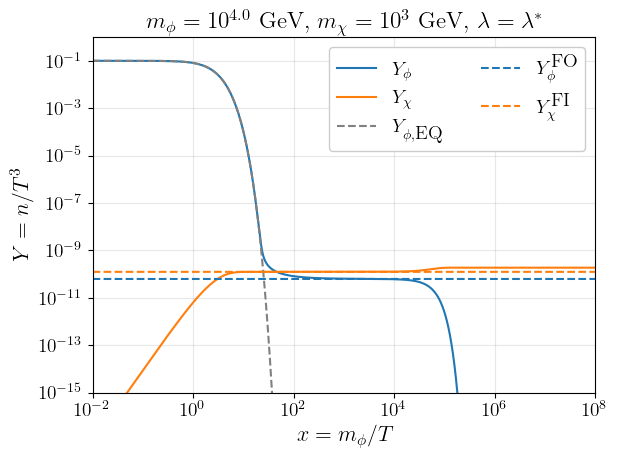

In [28]:
fig1 = figure()

plot(xrange, Yφs, label=L"$Y_\phi$", c="tab:blue")

plot(xrange, Yχs, label=L"$Y_\chi$", c="tab:orange")

plot(xrange, yeqs, label=L"$Y_{\phi,\textrm{EQ}}$", linestyle="dashed", c="grey")

plot(xrange, find_yφf(M.mφ)*ones(typeof(xrange[1]), length(xrange)), label=L"Y_\phi^{\textrm{FO}}",
        linestyle="dashed", c="tab:blue")

plot(xrange, find_yχf(M.λ, M.mφ, M.mχ)*ones(typeof(xrange[1]), length(xrange)), label=L"Y_\chi^{\textrm{FI}}",
        linestyle="dashed", c="tab:orange")

xlim(1e-2, 1e8)
ylim(1e-15, 1)

xscale("log")
yscale("log")

grid(alpha=0.3)

# title(L"$\lambda = 10^{%$(log10(M.λ))}$, $m_\phi = 10^{%$(log10(M.mφ))}$ GeV, $m_\chi = 10^{%$(Int(log10(M.mχ)))}$ GeV")
title(L"$m_\phi = 10^{%$(round(log10(M.mφ)))}$ GeV, $m_\chi = 10^{%$(Int(log10(M.mχ)))}$ GeV, $\lambda = \lambda^*$")
xlabel(L"x = m_\phi/T")
ylabel(L"Y = n/T^3")

legend(ncols=2, framealpha=1)
# savefig(figdir * "freezing.pdf")
fig1

In [17]:
fig1 = Figure()
ax1 = Axis(fig1[1,1], xlabel=L"$x = m_\phi / T$", ylabel=L"$Y = n / T^3$",
    title=L"$\lambda = 10^{%$(Int(log10(M.λ)))}$, $m_\phi = 10^{%$(Int(log10(M.mφ)))}$ GeV, $m_\chi = 10^{%$(Int(log10(M.mχ)))}$ GeV",
    xscale=log10, yscale=log10, xticklabelsize=16, yticklabelsize=16)
xlims!(1e-2, 1e6)
ylims!(1e-20, 1)
lines!(xrange, find_yφf(M.mφ)*ones(typeof(xrange[1]), length(xrange)),
        color=colors[1], linestyle=:dash, label=L"$Y_\phi^{\textrm{FO}}$")
lines!(xrange, Yφs, color=colors[1], label=L"$Y_\phi$")
lines!(xrange, find_yχf(M.λ, M.mφ, M.mχ)*ones(typeof(xrange[1]), length(xrange)), 
        color=colors[2], linestyle=:dash, label=L"$Y_\chi^{\textrm{FI}}$")
lines!(xrange, Yχs, color=colors[2], label=L"$Y_\chi$")
lines!(xrange, yeqs, color=:grey, linestyle=:dash, label=L"$Y_\phi^{\textrm{EQ}}$")
axislegend(ax1, labelsize=16)
# save("relic_11_4_-5.pdf", fig1)
fig1

UndefVarError: UndefVarError: `Figure` not defined

## Testing two different $m_\phi$ along the same $\tau_\phi$ and $m_\chi$:

In [62]:
τφ_test = 1e-4
λs_test, mφs_test, mχs_test = find_mφ_τ(τφ_test, 5e2)
Ms = LFDM.(λs_test, mφs_test, mχs_test)

2×1 Matrix{LFDM{Float64}}:
 LFDM{Float64}(8.29714324342176e-12, 4956.374935778076, 1.0, 500.0, 2.0, 3.3404138041346254e-11)
 LFDM{Float64}(7.316387856358583e-12, 24530.605450052175, 1.0, 500.0, 2.0, 8.182546842881e-10)

In [63]:
x0 = 1e-4
xf = 1e7
z0 = [-log(Y_eq(x0, 1)), 0.0]
y0 = 0.0
xspan = (x0, xf)

xrange = 10 .^range(log10(x0), log10(xf), 10000)
yeqs = Y_eq.(xrange, 1)

Yφs = zeros(typeof(x0), (length(Ms), length(xrange)))
Yχs = zeros(typeof(x0), (length(Ms), length(xrange)))

for (i, mm) in enumerate(Ms)
    prob = ODEProblem(diffeq, z0, xspan, mm)
    sol = solve(prob, Rodas4P(), reltol=1e-12)

    for (j,x) in enumerate(xrange)
        Yφs[i,j] = exp(-sol(x)[1])
        Yχs[i,j] = sol(x)[2]
    end
end
;

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/aradick/.julia/packages/SciMLBase/szsYq/src/integrator_interface.jl:606
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/aradick/.julia/packages/SciMLBase/szsYq/src/integrator_interface.jl:606


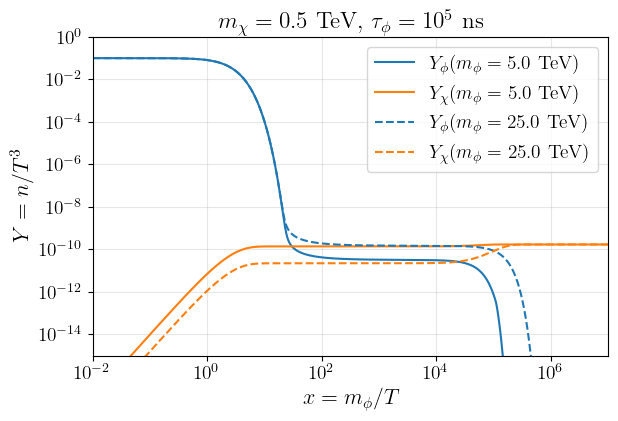

In [65]:
color = ["tab:blue", "tab:orange"]
LS = ["solid", "dashed", "dashdot"]
Labelφ = [L"$Y_\phi(m_\phi = %$(round(1e-3*Ms[1].mφ,sigdigits=2))$ TeV)",
        L"$Y_\phi(m_\phi = %$(round(1e-3*Ms[2].mφ,sigdigits=2))$ TeV)"]
Labelχ = [L"$Y_\chi(m_\phi = %$(round(1e-3*Ms[1].mφ,sigdigits=2))$ TeV)",
        L"$Y_\chi(m_\phi = %$(round(1e-3*Ms[2].mφ,sigdigits=2))$ TeV)"]

fig2 = figure()
xlabel(L"$x = m_\phi / T$")
ylabel(L"$Y = n / T^3$")
title(L"$m_\chi = %$(round(mχs_test[1]*1e-3, sigdigits=2))$ TeV, $\tau_\phi = 10^{%$(round(Int,log10(τφ_test*1e9)))}$ ns")
# xscale("log")
# yscale("log")
for i in range(1, length(Ms))
    plot(NaNMath.log10.(xrange), NaNMath.log10.(Yφs[i,:]), color=color[1], linestyle=LS[i], label=Labelφ[i])
    plot(NaNMath.log10.(xrange), NaNMath.log10.(Yχs[i,:]), color=color[2], linestyle=LS[i], label=Labelχ[i])
end
xlim(-2, 7)
ylim(-15, 0)
grid(alpha=0.3)
legend()

xticks = -2:2:6
yticks = -14:2:0

xticklabels = [L"10^{%$(round(Int,x))}" for x in xticks]
yticklabels = [L"10^{%$(round(Int,x))}" for x in yticks]

ax = gca()
ax.set_aspect((9)/(15*golden_ratio), adjustable="box")

ax.set_xticks(xticks, xticklabels)
ax.set_yticks(yticks, yticklabels)
# plot(xrange, yeqs, color=:grey, linestyle=:dash, label=L"$Y_\phi^{\textrm{EQ}}$")
plotclose()
fig2.savefig(figdir*"same_mchi_freeze.pdf", bbox_inches="tight")
fig2

## Contours of constant $\lambda$ and constant $\tau_\phi$:

In [11]:
Mphis = 10 .^ range(2, log10(2e4), 1000)
Mchis = 10 .^ range(-5, log10(3.6e3), 1000)

λs = find_λs(Mphis, Mchis)
τs = lifetime.(λs, Mphis, Mchis')

function mχ_upper_bound(mφ)
    min(Mstar_s(mφ/25)/find_yφf(mφ), mφ)
end

mχ_upper = mχ_upper_bound.(Mphis)
;

### $\lambda$ contours

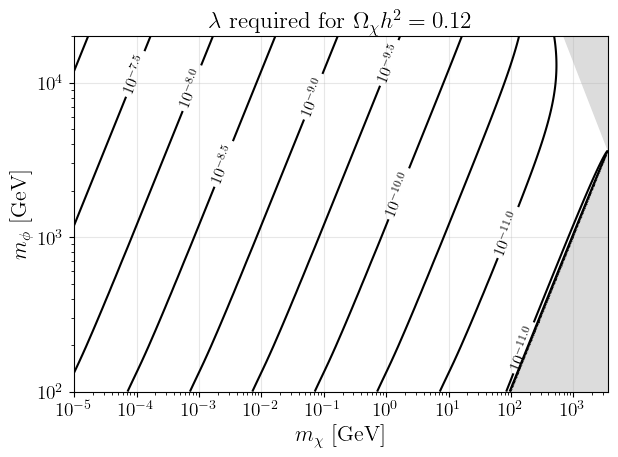

In [51]:
fig3 = figure()

xlim(1e-5, 3.6e3)
ylim(1e2, 2e4)

xscale("log")
yscale("log")

grid(alpha=0.3)

title(L"$\lambda$ required for $\Omega_\chi h^2 = 0.12$")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

levels = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11])
C = contour(Mchis, Mphis, λs, levels=levels, norm="log", colors="k")

formatter(l) = L"10^{ %$(log10(l)) }"

lvs = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -11])

fill_betweenx(Mphis, mχ_upper, 4e3, color="gainsboro")#, alpha=0.2)

clabel(C, lvs[1:end-3], colors="black", fmt=formatter, use_clabeltext=true, 
        inline=true, inline_spacing=5, fontsize=12)#, manual=((3e-5, 5e3), (3e-4, 4e3),
        # (3e-3, 3e3), (3e-2, 3e3), (3e-1, 3e3), (3e0, 3e3), (3e1, 3e2)))

plotclose()
fig3.savefig(figdir * "lambda_relic.pdf", bbox_inches="tight")
fig3

### $\tau_\phi$ contours

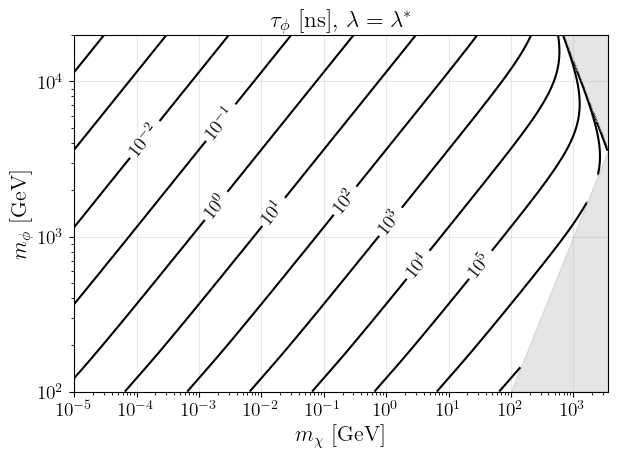

In [19]:
fig4 = figure()

xlim(1e-5, 3.6e3)
ylim(1e2, 2e4)

xscale("log")
yscale("log")

levels = 10.0 .^(-6:8)
C = contour(Mchis, Mphis, τs .* 1e9, levels=levels, norm="log", colors="black")

formatter(l) = L"10^{ %$(Int(log10(l))) }"

clabel(C, levels[5:end-3], colors="black", fmt=formatter, use_clabeltext=true, 
        inline=true)

fill_betweenx(Mphis, mχ_upper, 6e3, color="grey", alpha=0.2)

# plot(mχ_prompt, Mphis_life)

grid(alpha=0.3)

title(L"$\tau_\phi$ [ns], $\lambda = \lambda^*$")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

plotclose()
fig4.savefig(figdir * "phi_lifetime.pdf")
fig4

### Searches of interest overlaid

In [23]:
Mphis_life = 10 .^ range(2, log10(2e4), 100)
mχ_prompt = mχ_life.(3e-11, Mphis_life)
# mχ_ns = mχ_life.(1e-9, Mphis_life)
# mχ_ps = mχ_life.(1e-12, Mphis_life)
# mχ_minus5ns = mχ_life.(1e-14, Mphis_life)
# mχ_4plus4ns = mχ_life.(4e-5, Mphis_life)
# mχ_ms = mχ_life.(1e-3, Mphis_life)
# mχ_up = mχ_upper_bound.(Mphis_life)
;

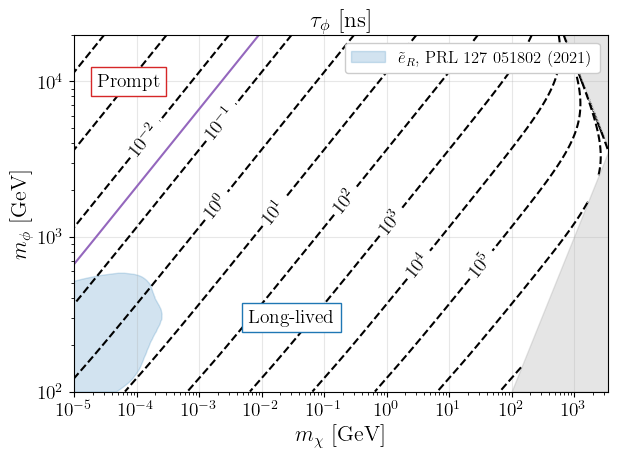

In [27]:
fig5 = figure()

xlim(1e-5, 3.5e3)
ylim(1e2, 2e4)

xscale("log")
yscale("log")

levels = 10.0 .^(-6:8)
C = contour(Mchis, Mphis, τs .* 1e9, levels=levels, norm="log", colors="black",
        linestyles="dashed")

formatter(l) = L"10^{ %$(Int(log10(l))) }"

clabel(C, levels[5:end-3], colors="black", fmt=formatter, use_clabeltext=true, inline=true)

fill_betweenx(Mphis, mχ_upper, 1e4, color="grey", alpha=0.2)

plot(mχ_prompt, Mphis_life, c="tab:purple")

fill_betweenx(seR_mphis, seR_lo_mχ, seR_hi_mχ, color="tab:blue", alpha=0.2, label=L"$\tilde{e}_R$, PRL 127 051802 (2021)")

# fill_betweenx(Mphis_life, mχ_minus5ns, mχ_ps, color="darkred", alpha=0.2, label="Prompt")
# fill_betweenx(Mphis_life, mχ_ps, mχ_ns, color="tab:blue", alpha=0.2, label="Displaced Vertex")
# fill_betweenx(Mphis_life, mχ_ns, mχ_4plus4ns, color="tab:orange", alpha=0.2, label="dE/dx")
# fill_betweenx(Mphis_life, mχ_4plus4ns, mχ_up, color="yellow", alpha=0.2, label="Stable")

grid(alpha=0.3)

title(L"$\tau_\phi$ [ns]")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

text(.75e-4, 1e4, "Prompt", ha="center", va="center", rotation=0.0,
    bbox=Dict("boxstyle" => "square", "ec" => "tab:red", "fc" => "w"))

text(3e-2, 3e2, "Long-lived", ha="center", va="center", rotation=0.0,
    bbox=Dict("boxstyle" => "square", "ec" => "tab:blue", "fc" => "w"))

legend(fontsize=12, framealpha=1, loc="upper right")

plotclose()
# fig5.savefig(figdir * "phi_decay_channels_2.pdf")
fig5

### smuon (displaced) and stau ($dE / dx$) bounds overlaid

In [24]:
import DelimitedFiles: readdlm
seR_dir = "../data/selectron_bounds/"
smuon_dir = "../data/smuon_bounds/"
stau_dir = "../data/stau_bounds/"

displ_lo_data = readdlm(smuon_dir * "Displaced_bottom.csv", ',')
displ_hi_data = readdlm(smuon_dir * "Displaced_top.csv", ',')
inter_lo_data = readdlm(smuon_dir * "Intermediate_bottom.csv", ',')
inter_hi_data = readdlm(smuon_dir * "Intermediate_top.csv", ',')
prompt_data = readdlm(smuon_dir * "Prompt.csv", ',')

stau_hi_data = readdlm(stau_dir * "stau_hi.csv", ',')
stau_lo_data = readdlm(stau_dir * "stau_lo.csv", ',')

displ_lo_func = linear_interpolation(displ_lo_data[:,1], displ_lo_data[:,2] .* 1e-9, extrapolation_bc=Line())
displ_hi_func = linear_interpolation(displ_hi_data[:,1], displ_hi_data[:,2] .* 1e-9, extrapolation_bc=Line())
inter_lo_func = linear_interpolation(inter_lo_data[:,1], inter_lo_data[:,2] .* 1e-9, extrapolation_bc=Line())
inter_hi_func = linear_interpolation(inter_hi_data[:,1], inter_hi_data[:,2] .* 1e-9, extrapolation_bc=Line())
prompt_func = linear_interpolation(prompt_data[:,1], prompt_data[:,2] .* 1e-9, extrapolation_bc=Line())

stau_lo_func = linear_interpolation(stau_lo_data[:,2], stau_lo_data[:,1] .* 1e-9, extrapolation_bc=Line())
stau_hi_func = linear_interpolation(stau_hi_data[:,2], stau_hi_data[:,1] .* 1e-9, extrapolation_bc=Line())
;

In [25]:
se_lo_data = readdlm(seR_dir * "seR_bounds_lower.csv", ',')
se_hi_data = readdlm(seR_dir * "seR_bounds_upper.csv", ',')

se_lo_func = linear_interpolation(se_lo_data[:,1], se_lo_data[:,2] .* 1e-9, extrapolation_bc=Line())
se_hi_func = linear_interpolation(se_hi_data[:,1], se_hi_data[:,2] .* 1e-9, extrapolation_bc=Line())
;

In [16]:
displ_Mphis = 10 .^range(2, log10(710), 100)
inter_Mphis = 10 .^range(2, log10(530), 100)
prompt_Mphis = 10 .^range(2, log10(549.31), 100)
stau_Mphis = 10 .^range(log10(200), log10(368), 100)

displ_lo_mχ = mχ_life.(displ_lo_func.(displ_Mphis), displ_Mphis)
displ_hi_mχ = mχ_life.(displ_hi_func.(displ_Mphis), displ_Mphis)
# inter_lo_mχ = mχ_life.(inter_lo_func.(inter_Mphis), inter_Mphis)
# inter_hi_mχ = mχ_life.(inter_hi_func.(inter_Mphis), inter_Mphis)
prompt_hi_mχ = mχ_life.(prompt_func.(prompt_Mphis), prompt_Mphis)

stau_lo_mχ = mχ_life.(stau_lo_func.(stau_Mphis), stau_Mphis)
stau_hi_mχ = mχ_life.(stau_hi_func.(stau_Mphis), stau_Mphis)
;

In [26]:
seR_mphis = 10 .^ range(2, log10(584), 100)

seR_lo_mχ = mχ_life.(se_lo_func.(seR_mphis), seR_mphis)
seR_hi_mχ = mχ_life.(se_hi_func.(seR_mphis), seR_mphis)
;

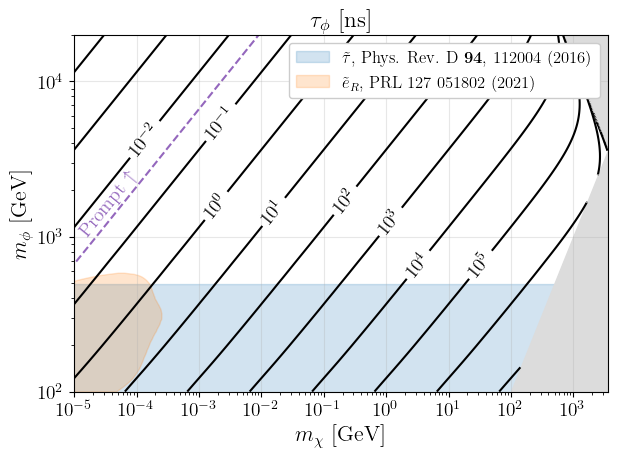

In [48]:
fig6 = figure()

xlim(1e-5, 3.6e3)
ylim(1e2, 2e4)

xscale("log")
yscale("log")

levels = 10.0 .^(-6:8)
C = contour(Mchis, Mphis, τs .* 1e9, levels=levels, norm="log", colors="black")

formatter(l) = L"10^{ %$(Int(log10(l))) }"

clabel(C, levels[5:end-3], colors="black", fmt=formatter, use_clabeltext=true, inline=true)

# fill_betweenx(displ_Mphis, displ_lo_mχ, displ_hi_mχ, color="tab:blue", alpha=0.2, label="Displaced, PRL 127 051802 (2021)")

# fill_betweenx(stau_Mphis, stau_lo_mχ, stau_hi_mχ, color="tab:orange", alpha=0.2, label="dE/dx, JHEP 06 (2023) 158")

fill_between(Mchis, 0, 490, color="tab:blue", alpha=0.2, label=L"$\tilde{\tau}$, Phys. Rev. D \textbf{94}, 112004 (2016)")

fill_betweenx(seR_mphis, seR_lo_mχ, seR_hi_mχ, color="tab:orange", alpha=0.2, label=L"$\tilde{e}_R$, PRL 127 051802 (2021)")

fill_betweenx(Mphis, mχ_upper, 1e4, color="gainsboro")#, alpha=0.2)

plot(mχ_prompt, Mphis_life, c="tab:purple", linestyle="dashed")

# fill_betweenx(inter_Mphis, inter_lo_mχ, inter_hi_mχ, color="tab:orange", alpha=0.2, label="Intermediate, arXiv:2305.02005")

# fill_betweenx(prompt_Mphis, prompt_hi_mχ, color="yellow", alpha=0.2)

text(1.1e-5, 1e3, L"Prompt $\uparrow$", rotation=51, c="tab:purple")

grid(alpha=0.3)

title(L"$\tau_\phi$ [ns]")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

legend(fontsize=12, framealpha=1)

plotclose()
fig6.savefig(figdir * "current_bounds.pdf")
fig6

In [13]:
# Mphis_life = 10 .^ range(3, log10(5e3), 50)
# mχ_prompt = mχ_life.(1e-11, Mphis_life)

Mphis_muc_bounds = 10 .^ range(2, log10(5e3), 100)
mχ_bounded = mχ_upper_bound.(Mphis_muc_bounds)
;

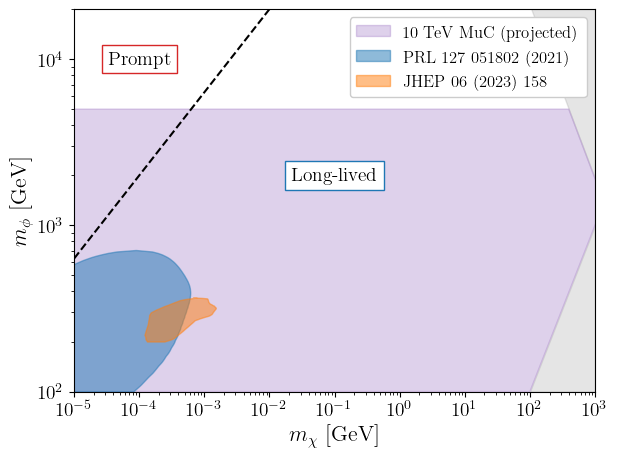

In [18]:
fig7 = figure()

xscale("log")
yscale("log")

xlim(1e-5, 1e3)
ylim(1e2, 2e4)

levels = [3e-2]
C = contour(Mchis, Mphis, τs .* 1e9, levels=levels, norm="log", colors="k",
    linestyles="dashed")

# formatter(l) = L"10^{ %$(Int(log10(l))) }"

# clabel(C, levels, colors="black", fmt=formatter, use_clabeltext=true, inline=true)

fill_betweenx(Mphis, mχ_upper, 1e3, color="grey", alpha=0.2)

fill_betweenx(Mphis_muc_bounds, 0, mχ_bounded, alpha=0.3, color="tab:purple", label="10 TeV MuC (projected)")

fill_betweenx(displ_Mphis, displ_lo_mχ, displ_hi_mχ, color="tab:blue", alpha=0.5, label="PRL 127 051802 (2021)")

fill_betweenx(stau_Mphis, stau_lo_mχ, stau_hi_mχ, color="tab:orange", alpha=0.5, label="JHEP 06 (2023) 158")

# fill_betweenx(Mphis_life, 0, mχ_prompt, color="tab:red", alpha=0.2)

# fill_betweenx(inter_Mphis, inter_lo_mχ, inter_hi_mχ, color="tab:orange", alpha=0.2, label="Intermediate, arXiv:2305.02005")

# fill_betweenx(prompt_Mphis, prompt_hi_mχ, color="yellow", alpha=0.2)

# grid(alpha=0.3)

# axhline(5e3, c="k", ls="dashed")
# axhline(1.5e3, c="k", ls="dashed")

text(1e-4, 1e4, "Prompt", ha="center", va="center", rotation=0.0,
    bbox=Dict("boxstyle" => "square", "ec" => "tab:red", "fc" => "w"))

text(1e-1, 2e3, "Long-lived", ha="center", va="center", rotation=0.0,
    bbox=Dict("boxstyle" => "square", "ec" => "tab:blue", "fc" => "w"))

# text(2e0, 1e3, "dE/dx", ha="center", va="center", rotation=0.0,
#     bbox=Dict("boxstyle" => "square", "ec" => "tab:orange", "fc" => "w"))

# text(5e1, 4e2, "Stable", ha="center", va="center", rotation=0.0,
#     bbox=Dict("boxstyle" => "square", "ec" => "k", "fc" => "w"))

# title("Searches")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

legend(fontsize=12, framealpha=1)

plotclose()
fig7.savefig(figdir * "3min_talk.pdf")
fig7

# Comparing $\lambda$ calculations

In [22]:
Mphis_test = 10 .^ range(2, log10(2e4), 10)
Mchis_test = 10 .^ range(-5, 3, 10)

λs = find_λs(Mphis_test, Mchis_test)
λs_full = find_λs_full(Mphis_test, Mchis_test)
;

In [11]:
rel_err = abs.((λs_full .- λs) ./ λs_full);

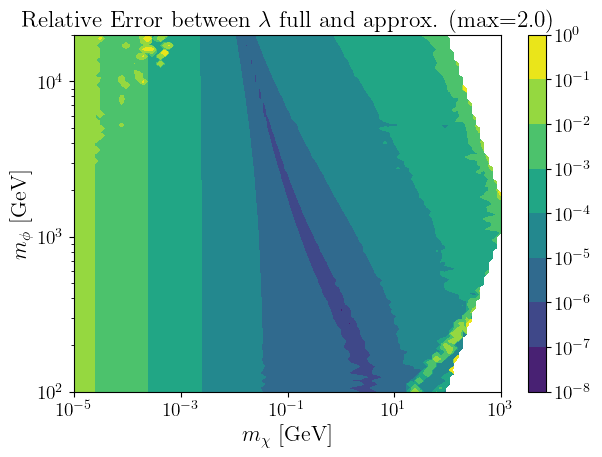

In [13]:
f17 = figure()
# pcm = pcolormesh(10 .^Mchis_test_log, 10 .^Mphis_test_log, rel_err, norm="log",
#             vmax=1, vmin=1e-6)
c = contourf(Mchis_test, Mphis_test, rel_err, levels=(10 .^ (-8.0:0.0)), norm="log")
xscale("log")
yscale("log")
title(L"Relative Error between $\lambda$ full and approx. (max=%$(round(maximum(filter(!isnan,rel_err)), sigdigits=3)))")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")
xlim(1e-5, 1e3)
colorbar(c)
plotclose()
f17.savefig(figdir*"lambda_rel_err.pdf")
f17